## Tracker Full Analysis
Analysis of approximately 1 month of CCTV footage from the Bentham Project Youtube Channel

In [1]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import math
from datetime import datetime,timedelta
import tracker_helpers as tracker
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D

In [2]:
source = os.path.join('results', 'tracker_2018-08-18_ssd_mobilenet_v2_coco__complex_feature_matching_3')
verbose = True

## 1. Extract Tracker Results
Extract and Process daily tracker results into pedestrian attributes, then concatenate all results togther.

In [3]:
# Loop through tests, loading results into lists of dictionaries
tests = ['test1', 'test2', 'test3', 'test4']
tests_short = ['Test 1', 'Test 2', 'Test 3', 'Test 4']

detection_models = ['ssd_mobilenet_v2_coco']

detection_models_short = ['ssd_mobilenet_v2']

odms = ['OD1']

association_models = ['complex_feature_matching']

oams = ['OA2']

comb = ['OD1+OA2']

head = ['frame',
       'ID',
       'left',
       'top',
       'width',
       'height',
       'conf',
       'trajectory',
       'duration',
       'x',
       'y',
       'dx',
       'dy',
       'distance_horizontal',
       'distance_vertical',
       'distance',
       'distance_accumulated',
       'direction',
       'x_av',
       'y_av',
       'direction_av',
       'year',
       'month',
       'day']

In [4]:
# test extract results
bad_days = ['2015-10-28.npy',
            '2015-10-29.npy',
            '2015-10-30.npy',
            '2015-10-31.npy',
            '2015-11-01.npy',
            '2015-11-02.npy',
            '2015-11-03.npy',
            '2015-11-04.npy',
            '2015-12-04.npy',
            '2015-12-05.npy',
            '2015-12-06.npy',
            '2015-12-07.npy',
            '2015-12-08.npy',
            '2015-12-09.npy',
            '2015-12-10.npy',
            '2016-02-08.npy'
           ]
results_paths = os.listdir(source)
results_paths = sorted([path for path in results_paths if (path[0] is not 'p') and (path[-1:] is not 't') and (path not in bad_days)])
print('{} days:'.format(len(results_paths)))
results_paths

31 days:


['2015-11-05.npy',
 '2015-11-06.npy',
 '2015-11-07.npy',
 '2015-11-08.npy',
 '2015-11-09.npy',
 '2015-11-10.npy',
 '2015-11-11.npy',
 '2015-11-12.npy',
 '2015-11-13.npy',
 '2015-11-14.npy',
 '2015-11-15.npy',
 '2015-11-16.npy',
 '2015-11-17.npy',
 '2015-11-18.npy',
 '2015-11-19.npy',
 '2015-11-20.npy',
 '2015-11-21.npy',
 '2015-11-22.npy',
 '2015-11-23.npy',
 '2015-11-24.npy',
 '2015-11-25.npy',
 '2015-11-26.npy',
 '2015-11-27.npy',
 '2015-11-28.npy',
 '2015-11-29.npy',
 '2015-11-30.npy',
 '2015-12-01.npy',
 '2015-12-11.npy',
 '2015-12-12.npy',
 '2015-12-13.npy',
 '2015-12-14.npy']

In [5]:
results = {}
unique_results = {}
trajectory_dicts = {}
start_id = 0
for path in results_paths[5:]:
    raw_result = np.load(os.path.join(source, path))
    if verbose:
        print('\n\t {} \t> {} detections'.format(path, len(raw_result)))
    date = datetime.strptime(path[:10], '%Y-%m-%d')
    
    analysis, start_id = tracker.get_analysis(raw_result, start_id, date)
    uniques = tracker.get_ID_aggregation(analysis)
    trajectories = tracker.get_trajectory_dict(uniques, analysis)
    
    results[date] = analysis
    unique_results[date] = uniques
    trajectory_dicts[date] = trajectories
    


	 2015-11-10.npy 	> 3029 detections
Created results analysis array with shape: (3029, 24)
Created unique ids array with shape: (1257, 24)
Created unique trajectories dict of length 1257

	 2015-11-11.npy 	> 6898 detections
Created results analysis array with shape: (6898, 24)
Created unique ids array with shape: (1986, 24)
Created unique trajectories dict of length 1986

	 2015-11-12.npy 	> 5083 detections
Created results analysis array with shape: (5083, 24)
Created unique ids array with shape: (1675, 24)
Created unique trajectories dict of length 1675

	 2015-11-13.npy 	> 4589 detections
Created results analysis array with shape: (4589, 24)
Created unique ids array with shape: (1606, 24)
Created unique trajectories dict of length 1606

	 2015-11-14.npy 	> 1429 detections
Created results analysis array with shape: (1429, 24)
Created unique ids array with shape: (653, 24)
Created unique trajectories dict of length 653

	 2015-11-15.npy 	> 1892 detections
Created results analysis array

In [6]:
length = 0
for res in results.values():
    length += len(res)
length

137318

In [7]:
# Loop through all unique results concatenating arrays
all_unique_results = np.zeros((0, 24))
for date, result in unique_results.items():
    all_unique_results = np.concatenate((all_unique_results, result))
all_unique_results.shape

(38020, 24)

In [8]:
# 720p: 1280x720 ??

## 2. Calculate Pedestrian Clusters
Cluster results using min-max standardised pedestrian duration, distance, horizontal distance and vertical distance as features. Cluster using K-means with elbow method for deciding on number of cluisters.

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [10]:
#extract duration, dx_acc, dy_acc and distance_acc
X = all_unique_results[:,[8,13,14,16]]
len(X[X[:,1] != 0])

20533

In [11]:
mms = MinMaxScaler()
mms.fit(X)
X_norm = mms.transform(X)
X_norm[:3]

array([[0.        , 0.50312221, 0.50136737, 0.        ],
       [0.        , 0.50312221, 0.50136737, 0.        ],
       [0.        , 0.50312221, 0.50136737, 0.        ]])

In [12]:
ssd = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_norm)
    ssd.append(km.inertia_)

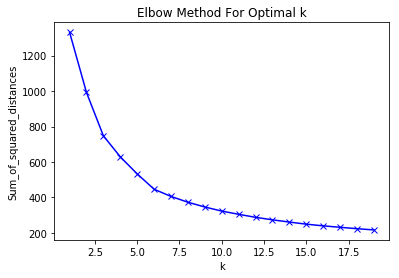

In [13]:
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Slight elbows at 3 and 6 clusters

In [14]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_norm)
y_class = kmeans.fit_predict(X_norm)

In [15]:
y_class.shape

(38020,)

In [16]:
data_split = []
classes = np.unique(y_class)
print(classes)
for cl in classes:
    split = all_unique_results[y_class==cl]
    df = pd.DataFrame(split)
    df.columns = head
    print(df.describe())
    data_split.append(df)


[0 1 2 3 4 5]
              frame            ID         left          top        width  \
count   3724.000000   3724.000000  3724.000000  3724.000000  3724.000000   
mean   10858.296992  20187.589420   406.292159    38.383996    95.777927   
std     2760.677924  11149.865744   106.647836    54.653429    35.637208   
min       10.000000     74.000000    11.000000     0.000000    27.000000   
25%     9005.000000  10832.000000   328.750000     0.000000    71.000000   
50%    10768.000000  21017.000000   426.000000     8.000000    87.000000   
75%    13129.750000  30158.250000   491.000000    58.000000   112.000000   
max    16624.000000  37994.000000   602.000000   269.000000   625.000000   

            height         conf  trajectory     duration            x   ...    \
count  3724.000000  3724.000000      3724.0  3724.000000  3724.000000   ...     
mean    180.447100     0.752769         1.0     7.039742   454.181122   ...     
std      69.023998     0.150172         0.0     5.033386  

              frame            ID         left          top        width  \
count   2362.000000   2362.000000  2362.000000  2362.000000  2362.000000   
mean   10517.780694  17864.686706   234.319221    99.731583   127.954699   
std     2741.223851  10546.746875   126.288378    68.734392    38.329332   
min        5.000000     60.000000     0.000000     0.000000    61.000000   
25%     8846.500000   8945.250000   142.000000    41.000000    99.000000   
50%    10392.000000  17471.500000   239.000000    87.000000   120.000000   
75%    12539.500000  26556.500000   322.750000   154.000000   152.000000   
max    16667.000000  37964.000000   548.000000   298.000000   302.000000   

            height         conf  trajectory     duration            x   ...    \
count  2362.000000  2362.000000      2362.0  2362.000000  2362.000000   ...     
mean    217.283235     0.849336         1.0     6.599492   298.296571   ...     
std      55.659777     0.134839         0.0     5.084176   124.333340   

In [ ]:
labels = {'A': 'A: Bottom to Top', 'B': 'B: Top to Bottom',
          'C': 'C: Left to Right', 'D': 'D: Right to Left',
          'E': 'E: Long Stay', 'F': 'F: Short Stay'}


In [17]:
df_long = pd.DataFrame(all_unique_results, columns=head)
df_long['class'] = y_class
map_dict = {0: "F", 1: "B", 2: "C", 3: "A", 4: "D", 5: "E"}
df_long["class"] = df_long.loc[:,"class"].map(map_dict)
df_long.head()

,frame,ID,left,top,width,height,conf,trajectory,duration,x,...,distance,distance_accumulated,direction,x_av,y_av,direction_av,year,month,day,class
0,16264.0,1256.0,426.0,1.0,75.0,105.0,0.868184,0.0,1.0,463.5,...,0.0,0.0,0.0,463.5,53.5,0.0,0.0,0.0,0.0,C
1,16205.0,1255.0,441.0,0.0,54.0,114.0,0.664366,0.0,1.0,468.0,...,0.0,0.0,0.0,468.0,57.0,0.0,0.0,0.0,0.0,C
2,16180.0,1254.0,378.0,0.0,79.0,80.0,0.598402,0.0,1.0,417.5,...,0.0,0.0,0.0,417.5,40.0,0.0,0.0,0.0,0.0,C
3,15964.0,1253.0,346.0,1.0,75.0,94.0,0.850384,0.0,1.0,383.5,...,0.0,0.0,0.0,383.5,48.0,0.0,0.0,0.0,0.0,C
4,15962.0,1252.0,376.0,4.0,93.0,137.0,0.950968,0.0,1.0,422.5,...,0.0,0.0,0.0,422.5,72.5,0.0,0.0,0.0,0.0,C


In [18]:
df_long_plot = df_long[['duration','distance_accumulated','distance_horizontal','distance_vertical','class']]
df_long_plot.loc[:,'distance_vertical'] *= -1
df_long_plot.tail()

/Users/fredshone/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,duration,distance_accumulated,distance_horizontal,distance_vertical,class
38015,1.0,0.0,0.0,-0.0,C
38016,1.0,0.0,0.0,-0.0,C
38017,1.0,0.0,0.0,-0.0,C
38018,1.0,0.0,0.0,-0.0,C
38019,1.0,0.0,0.0,-0.0,C


## 3. Examine Clusters
Examine clusters using grid of pair-plots. Note that clusters are identified randomly so plots may not work and descripotios may be incorrect.

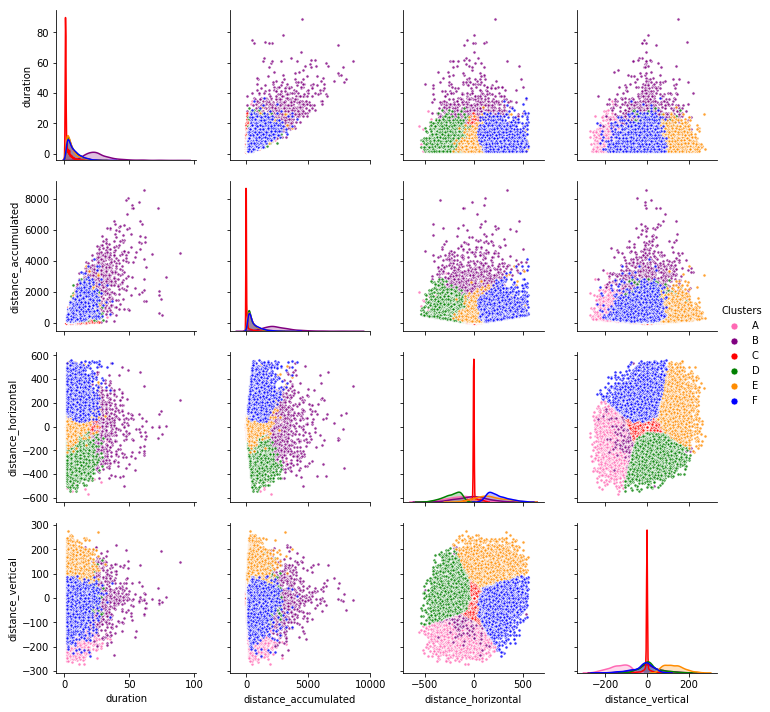

In [19]:
colours = {'A': 'hotpink', 'B': 'purple', 'C': 'red', 'D': 'green', 'E': 'darkorange', 'F': 'blue'}
g = sns.pairplot(df_long_plot, hue='class', markers='o', palette=colours, hue_order=colours.keys(),
                     height=2.5, plot_kws={'s':10, 'alpha': 0.8})
g._legend.set_title("Clusters")

for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50]

In [ ]:
#g.savefig('figures/scatter.png', bbox_inches='tight')

## 4. Visualise Tracker Results
Visualise tracker results using clusters. First cluster IDs are added back to original tracker results. Then temporal and spatial patterns plotted.

In [ ]:
# add clusters back to analysis
results_clustered = np.zeros((0, 25))
for date, result in results.items():
    print('{} results from {}'.format(len(result), date))
    for line in result:
        ID = line[1]
        cluster = y_class[all_unique_results[:,1]==ID]
        new_line = np.concatenate((cluster, line))
        results_clustered = np.concatenate((results_clustered, [new_line]))
        

3029 results from 2015-11-10 00:00:00
6898 results from 2015-11-11 00:00:00
5083 results from 2015-11-12 00:00:00
4589 results from 2015-11-13 00:00:00
1429 results from 2015-11-14 00:00:00
1892 results from 2015-11-15 00:00:00
7634 results from 2015-11-16 00:00:00
7676 results from 2015-11-17 00:00:00
7913 results from 2015-11-18 00:00:00
8686 results from 2015-11-19 00:00:00
10209 results from 2015-11-20 00:00:00
61 results from 2015-11-21 00:00:00
374 results from 2015-11-22 00:00:00
1870 results from 2015-11-23 00:00:00
10621 results from 2015-11-24 00:00:00
6768 results from 2015-11-25 00:00:00
5987 results from 2015-11-26 00:00:00
6962 results from 2015-11-27 00:00:00
1001 results from 2015-11-28 00:00:00
2113 results from 2015-11-29 00:00:00
10627 results from 2015-11-30 00:00:00
3093 results from 2015-12-01 00:00:00
4823 results from 2015-12-11 00:00:00
3552 results from 2015-12-12 00:00:00
7187 results from 2015-12-13 00:00:00
7241 results from 2015-12-14 00:00:00


In [ ]:
results_df = pd.DataFrame(results_clustered, columns=['cluster'] + head)
results_df.head(10)

In [ ]:
df_long_plot[['class','distance_vertical']].groupby('class').describe()

In [ ]:
results_clustered.shape

In [ ]:
results_df['seconds'] = results_df.frame*3
results_df.head()

In [ ]:
results_df['date'] = pd.to_datetime(results_df['seconds'], unit='s')

In [ ]:
results_df.loc[:,'distance_vertical'] *= -1

In [ ]:
df_long_plot[['class','duration']].groupby('class').describe()

In [ ]:
df_long_plot[['class','distance_accumulated']].groupby('class').describe()

In [ ]:
df_long_plot[['class','distance_horizontal']].groupby('class').describe()

In [ ]:
df_long_plot[['class','distance_vertical']].groupby('class').describe()

In [ ]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F']
all_names = ['Total'] + class_names

timestamps = []
crowding = []
dwelling = []
distance = []
direction_x = []
direction_y = []

frame_counter_max = max(results_df.frame)
frame_counter = 0
frame_bin = 100

start_time = datetime(2015, 1, 1, 8, 0, 0)
           
while frame_counter <= frame_counter_max:
    frame_limit = frame_counter + frame_bin
    df_temp = df_long[(df_long['frame'] >= frame_counter) & (df_long['frame'] < frame_limit)]
    
    timestamp = start_time + timedelta(days=0, seconds=frame_limit*3, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0)
    
    crowding_counter = [0]*7
    dwelling_counter = [0]*7
    distance_counter = [0]*7
    direction_x_counter = [0]*7
    direction_y_counter = [0]*7
    
    crowding_counter[0] = len(df_temp)
        
    if len(df_temp):
        dwelling_counter[0] = sum(df_temp.duration)
        distance_counter[0] = sum(df_temp.distance_accumulated)
        direction_x_counter[0] = sum(df_temp.distance_horizontal)
        direction_y_counter[0] = -sum(df_temp.distance_vertical)
    else:
        dwelling_counter[0] = None
        distance_counter[0] = None
        direction_x_counter[0] = None
        direction_y_counter[0] = None
    
    for i, cl in enumerate(class_names):
        df_temp_class = df_temp[df_temp['class'] == cl]
        crowding_counter[i+1] = len(df_temp_class)
        
        if len(df_temp_class):
            dwelling_counter[i+1] = sum(df_temp_class.duration)
            distance_counter[i+1] = sum(df_temp_class.distance_accumulated)
            direction_x_counter[i+1] = sum(df_temp_class.distance_horizontal)
            direction_y_counter[i+1] = -sum(df_temp_class.distance_vertical)
        else:
            dwelling_counter[i+1] = None
            distance_counter[i+1] = None
            direction_x_counter[i+1] = None
            direction_y_counter[i+1] = None
            
        
    timestamps.append(timestamp.time())
    crowding.append(crowding_counter)
    dwelling.append(dwelling_counter)
    distance.append(distance_counter)
    direction_x.append(direction_x_counter)
    direction_y.append(direction_y_counter)
    
    frame_counter = frame_limit
    
crowding = pd.DataFrame(crowding, index=timestamps, columns=all_names)
dwelling = pd.DataFrame(dwelling, index=timestamps, columns=all_names)
distance = pd.DataFrame(distance, index=timestamps, columns=all_names)
direction_x = pd.DataFrame(direction_x, index=timestamps, columns=all_names)
direction_y = pd.DataFrame(direction_y, index=timestamps, columns=all_names)

In [ ]:
assert (len(crowding) == len(dwelling) == len(distance) == len(direction_x) == len(direction_y)),'miss-matched vector lengths'

## 4. Temporal Patterns

In [ ]:
import matplotlib.ticker as ticker

In [ ]:
colours = ['black', 'hotpink', 'purple', 'red', 'green', 'darkorange', 'blue']
linestyles = ['-', '-', '-', '-', '-', '-', '-']
linewidths = [3, 2 ,2 ,2 ,2 ,2 ,2]
chart_names = ['Crowding', 'Dwelling (frames)', 'Distance (pixels)', 'Horizontal Distance (pixels)', 'Vertical Distance (pixels)']

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 16), gridspec_kw = {'height_ratios':[1,1,1,1,1]})
for row, (data, name) in enumerate(zip([crowding, dwelling, distance, direction_x, direction_y], chart_names)):
    axes[row].set_ylabel(name, size='x-large')
    
    for cl, col, ls, lw in zip(all_names, colours, linestyles, linewidths):
        axes[row].plot(data[cl], c=col, linestyle=ls, linewidth=lw)
        axes[row].set_xlabel('')
        start, end = axes[row].get_xlim()
        axes[row].xaxis.set_ticks(np.arange(start, end, 3600))
        axes[row].set_xticklabels(['07:00','08:00','09:00','10:00','11:00','12:00',
                                   '13:00','14:00','15:00','16:00','17:00','18:00'
                                  ,'19:00','20:00','21:00','22:00','23:00','24:00'])
    
    axes[4].set_xlabel('Time', size='x-large')

    axes[0].legend()

fig.tight_layout()
plt.show()

In [ ]:
#fig.savefig('figures/timeseries.png', bbox_inches='tight')

In [ ]:
def create_grid(image, step):
    h, w = image.shape[:2]
    h_steps = int(h / step)
    h_buffer = int((h - ((h_steps - 1) * step)) / 2)
    w_steps = int(w / step)
    w_buffer = int((w - ((w_steps - 1) * step)) / 2)
    
    grid = []
    
    for row in range(h_steps):
        for col in range(w_steps):
            y = h_buffer + (row * step)
            x = w_buffer + (col * step)
            grid.append([x, y])
    return grid
            

In [ ]:
def dist_to_point(x1,y1, x2,y2):
    dx = x2-x1
    dy = y2-y1
    dist = math.sqrt(dx*dx + dy*dy)

    return dist

In [ ]:
def dist_to_line(x1,y1, x2,y2, x3,y3): # x3,y3 is the point
    px = x2-x1
    py = y2-y1
    
    if px == 0 and py == 0:
        dist = dist_to_point(x1,y1, x3, y3)
        return dist

    something = px*px + py*py

    u =  ((x3 - x1) * px + (y3 - y1) * py) / float(something)

    if u > 1:
        u = 1
    elif u < 0:
        u = 0

    x = x1 + u * px
    y = y1 + u * py

    dx = x - x3
    dy = y - y3

    dist = math.sqrt(dx*dx + dy*dy)

    return dist

In [ ]:
def get_kernel_results(grid, max_kernel_size, unique_detections, trajectory_dict):
    g_trajectory = []
    g_distance = []
    g_dx = []
    g_dy = []

    for point in grid:
        p_trajectory = 0
        p_distance = 0
        p_dx = 0
        p_dy = 0

        for unique in unique_detections:
            ID = unique[1]
            trajectory = unique[7]
            x, y = unique[9], unique[10]

            if not trajectory:
                dist = dist_to_point(x, y, point[0], point[1])
                if dist < max_kernel_size:
                    p_trajectory += 1

            else:  
                distance = unique[15]
                dx = unique[11]
                dy = unique[12]
                trajectory_x, trajectory_y = trajectory_dict.get(ID)
                for x1, y1, x2, y2 in zip(trajectory_x[1:], trajectory_y[1:], trajectory_x[:-1], trajectory_y[:-1]):
                    dist = dist_to_line(x1, y1, x2, y2, point[0], point[1])
                    if dist < max_kernel_size:
                        p_trajectory += 1
                        p_distance += distance
                        p_dx = dx
                        p_dy = dy

        g_trajectory.append(p_trajectory)
        g_distance.append(p_distance)
        g_dx.append(p_dx)
        g_dy.append(p_dy)

    # norm
    g_trajectory = [float(i)/max(g_trajectory) for i in g_trajectory]
    g_distance = [float(i)/max(g_distance) for i in g_distance]
    g_dx = [float(i)/max(g_dx) for i in g_dx]
    g_dy = [float(i)/max(g_dy) for i in g_dy]
    
    return g_trajectory, g_distance, g_dx, g_dy
 

## 5. Spatial Patterns

In [ ]:
# join trajectory dicts
all_trajectories = {}
for d in trajectory_dicts.values():
    all_trajectories.update(d) 

In [ ]:
results_clustered.shape

In [ ]:
data_split[2].describe()


In [ ]:
step_size = 40
max_kernel_size = 90
correction = 2
rows = 3
cols = 2
colours = {'A': 'hotpink', 'B': 'purple', 'C': 'red', 'D': 'green', 'E': 'darkorange', 'F': 'blue'}
cls = ['A','B','C','D','E','F']
map_dict = {0: "F", 1: "B", 2: "C", 3: "A", 4: "D", 5: "E"}
inv_map = {v: k for k, v in map_dict.items()}
labels = {'A': 'A: Bottom to Top', 'B': 'B: Top to Bottom',
          'C': 'C: Left to Right', 'D': 'D: Right to Left',
          'E': 'E: Long Stay', 'F': 'F: Short Stay'}

frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (640,360))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 80

grid = tracker.create_grid(frame, step_size)

fig, axes = plt.subplots(nrows=rows, ncols=cols, sharey=True, sharex=True, figsize=(14, rows*4.2))


for row in range(rows):
    for col in range(cols):
        index = (row * cols) + col
        cl = cls[index]
        index = inv_map[cl]
        colour = colours.get(cl)
        label = labels[cl]
        print(index)
        print(label)
        
        unique_detections = np.array(data_split[index])
        g_trajectory, g_distance, g_dx, g_dy = tracker.get_kernel_results(grid,
                                                                  max_kernel_size,
                                                                  unique_detections,
                                                                  all_trajectories)
        
        
        axes[row,col].imshow(frame)

        for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

            axes[row,col].arrow(point[0], point[1],
                                  p_dx*step_size/correction,
                                  p_dy*step_size/correction,
                                  edgecolor=colour,
                                  linewidth=1.5)

            axes[row,col].scatter(point[0], point[1],
                                    s=p_trajectory*step_size*10,
                                    c=colour,
                                    alpha=.4,
                                    label = cl)
            
        axes[row,col].axis('off')
        axes[row,col].axis('off')
        axes[row, col].set_title(label, size='x-large')

legend_elements = [Line2D([0], [0], color='black', lw=2, label='Average Flow'),
                   Line2D([0], [0], marker='o', color='w', label='High Trajectory Density',
                          markerfacecolor='black', alpha = 0.4, markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Low Trajectory Density',
                          markerfacecolor='black', alpha = 0.4, markersize=8),]

pad = 10
rows = ['Actual'] + comb

axes[0,1].legend(handles=legend_elements, loc=2)
    
fig.tight_layout()
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.06)

plt.show()

In [ ]:
#fig.savefig('figures/spatial.png', bbox_inches='tight')